In [1]:
%matplotlib widget
import copy

import cartopy
import cartopy.crs as ccrs
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import colors
from matplotlib.animation import FuncAnimation, PillowWriter, writers

### necessary packages

In [ ]:
#mamba install conda-forge::parcels
#mamba install trajan cartopy

### Modified (enabling different colours and filtered trajectories) code from parcels tutorial used
#### input file can be downloaded from https://surfdrive.surf.nl/files/index.php/s/lwjW5w05jtHuYz9

In [2]:
filename = "medusarun.nc"
pfile = xr.open_dataset(str(filename), decode_cf=True)
lon = np.ma.filled(pfile.variables["lon"], np.nan)
lat = np.ma.filled(pfile.variables["lat"], np.nan)
time = np.ma.filled(pfile.variables["time"], np.nan)

pfile.close()

plottimes = np.arange(time[0, 0], np.nanmax(time), np.timedelta64(10, "D"))
starttime = 0
b = time == plottimes[0 + starttime]


In [3]:
pfile

<xarray.Dataset> Size: 111MB
Dimensions:     (traj: 10491, obs: 439)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) int32 18MB ...
    time        (traj, obs) datetime64[ns] 37MB 2000-01-03T12:00:00 ... 2005-...
    lat         (traj, obs) float32 18MB -76.0 -75.96 -75.96 ... 62.85 62.85
    lon         (traj, obs) float32 18MB -179.0 -179.6 -180.5 ... 318.2 318.2
    z           (traj, obs) float32 18MB ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical

In [12]:
plottimes = np.arange(time[0, 0], np.nanmax(time), np.timedelta64(10, "D"))


In [13]:
trajectory_lon = lon[:, 0]
trajectory_lat = lat[:, 0]
trajectory_time = time[:, 0]

In [15]:
# Assuming 'lon', 'lat', 'time' have shape (nr_particles, nr_timesteps)

# Extract number of particles and timesteps
nr_particles, nr_timesteps = lon.shape

# Create a list to store the valid trajectories
trajectories = []

# Loop over all particles to extract their trajectories
for i in range(nr_particles):
    particle_lon = lon[i, :]
    particle_lat = lat[i, :]
    particle_time = time[i, :]
    
    # Check if any NaNs exist in the particle's data
    if (
        np.isnan(particle_lon).any() or
        np.isnan(particle_lat).any() or
        np.isnan(particle_time).any()
    ):
        continue  # Skip this particle if any NaNs are found
    
    # Store the trajectory of the i-th particle in a dictionary
    trajectories.append({
        "lon": particle_lon,
        "lat": particle_lat,
        "time": particle_time
    })


In [17]:
import random
num_random_trajectories = 1000  

random_indices = random.sample(range(len(trajectories)), num_random_trajectories)

trajectories = [trajectories[i] for i in random_indices]

In [23]:
import pandas as pd

selected_trajectories = trajectories

records = []
obj_id_map = {}  # new obj_id -> original particle index
t_map = {}       # new t index -> original time 

for new_id, (original_idx, trajectory) in enumerate(zip(random_indices, selected_trajectories)):
    obj_id_map[new_id] = original_idx  # Map new obj_id to original particle index

    lons = trajectory["lon"]
    lats = trajectory["lat"]
    times = trajectory["time"]

    for t_idx, (lon, lat, t_val) in enumerate(zip(lons, lats, times)):
        if new_id == 0:

            t_map[t_idx] = t_val
        records.append({
            "obj_id": new_id,
            "t": t_idx,
            "lon": lon,
            "lat": lat
        })

df = pd.DataFrame(records)

df = df.sort_values(by=["obj_id", "t"]).reset_index(drop=True)

#no true labels
df["label"] = 0


   obj_id  t         lon        lat
0       0  0 -157.000000 -72.000000
1       0  1 -156.526947 -71.916222
2       0  2 -156.291870 -71.905563
3       0  3 -155.832520 -71.952057
4       0  4 -155.694901 -71.947189

Object ID map: {0: 108, 1: 5501, 2: 170, 3: 9796, 4: 10222, 5: 811, 6: 8301, 7: 262, 8: 5914, 9: 7775, 10: 7266, 11: 5512, 12: 986, 13: 9674, 14: 3438, 15: 7766, 16: 3565, 17: 4792, 18: 6172, 19: 2474, 20: 10041, 21: 9587, 22: 7556, 23: 6614, 24: 1341, 25: 8554, 26: 459, 27: 8042, 28: 9023, 29: 5112, 30: 9667, 31: 519, 32: 6537, 33: 3506, 34: 2094, 35: 1988, 36: 5157, 37: 458, 38: 10346, 39: 8770, 40: 1472, 41: 2281, 42: 2484, 43: 842, 44: 5889, 45: 8256, 46: 7227, 47: 5396, 48: 3664, 49: 1464, 50: 6306, 51: 8827, 52: 5563, 53: 5514, 54: 5, 55: 1961, 56: 7712, 57: 3179, 58: 2656, 59: 9370, 60: 3584, 61: 2787, 62: 940, 63: 4933, 64: 9833, 65: 7788, 66: 7049, 67: 4485, 68: 1480, 69: 5143, 70: 999, 71: 9848, 72: 10224, 73: 3177, 74: 2916, 75: 2895, 76: 8593, 77: 8998, 78: 950

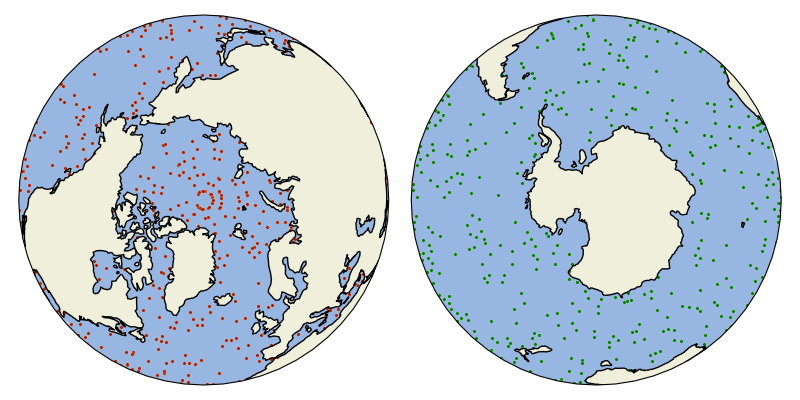

In [25]:
# Plotting without cluster labels


fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(ncols=8, nrows=4, figure=fig)

times = starttime
lats = []
lons = []
for trajelem in trajectories:
    lona = trajelem["lon"][times]
    lons.append(lona)

    lata = trajelem["lat"][times]
    lats.append(lata)
stack = np.vstack((np.array(lons), np.array(lats))).transpose()


### Northern Hemisphere
ax1 = fig.add_subplot(
    gs[:, :4],
    projection=ccrs.NearsidePerspective(
        central_latitude=90, central_longitude=-30, satellite_height=15000000
    ),
)
ax1.add_feature(cartopy.feature.LAND, zorder=1)
ax1.add_feature(cartopy.feature.OCEAN, zorder=1)
ax1.coastlines()
scat1 = ax1.scatter(
    np.array(lons),
    np.array(lats),
    marker=".",
    s=25,
    c="#AB2200",
    edgecolor="white",
    linewidth=0.15,
    transform=ccrs.PlateCarree(),
)

### Southern Hemisphere
ax2 = fig.add_subplot(
    gs[:, 4:],
    projection=ccrs.NearsidePerspective(
        central_latitude=-90, central_longitude=-30, satellite_height=15000000
    ),
)
ax2.add_feature(cartopy.feature.LAND, zorder=1)
ax2.add_feature(cartopy.feature.OCEAN, zorder=1)
ax2.coastlines()
scat2 = ax2.scatter(
    np.array(lons),
    np.array(lats),
    marker=".",
    s=25,
    c="green",
    edgecolor="white",
    linewidth=0.15,
    transform=ccrs.PlateCarree(),
)

frames = np.arange(0, 20)


def animate(t):
    b = time == plottimes[t + starttime]

    times = t+ starttime
    lats = []
    lons = []
    for trajelem in trajectories:
        lona = trajelem["lon"][times]
        lons.append(lona)

        lata = trajelem["lat"][times]
        lats.append(lata)
    stack = np.vstack((np.array(lons), np.array(lats))).transpose()

    scat1.set_offsets(stack)
    scat2.set_offsets(stack)


    return scat1, scat2


anim = animation.FuncAnimation(fig, animate, frames=frames, interval=150, blit=True)
anim

# needed for tight_layout to work with cartopy
fig.canvas.draw()
plt.tight_layout()


In [30]:
# order is not really necessary
cols = list(df.columns)
cols.remove('lat')
cols.insert(cols.index('lon'), 'lat')
df = df[cols]


In [31]:
df

,obj_id,t,lat,lon,label
0,0,0,-72.000000,-157.000000,0
1,0,1,-71.916222,-156.526947,0
2,0,2,-71.905563,-156.291870,0
3,0,3,-71.952057,-155.832520,0
4,0,4,-71.947189,-155.694901,0
...,...,...,...,...,...
438995,999,434,80.502853,-17.479082,0
438996,999,435,80.502853,-17.479082,0
438997,999,436,80.502853,-17.479082,0
438998,999,437,80.502853,-17.479082,0


In [36]:
import redpandda_general
traj_array, point_array, frames_count, n_objects = redpandda_general.prepare_data_from_df_ndim(df, coord_columns=["lat", "lon"])

dist_matrices = redpandda_general.get_distance_matrices(traj_array, metric="haversine")
delta_matrices = redpandda_general.get_delta_matrices(dist_matrices)
average_delta_matrix = redpandda_general.calculate_average_delta_matrix(delta_matrices)

std_delta_matrix = redpandda_general.get_std_matrices(dist_matrices)

stddv_matrices = redpandda_general.get_stddv(dist_matrices)

In [94]:
import distance_matrix as dm

#clustering, k_cluster, matrix = dm.hdbscan_clustering_on_deltas(average_delta_matrix, min_cluster_size=2, min_samples=1)


0.0455


In [59]:
#clustering= dm.affinity_propagation_on_deltas(average_delta_matrix, damping=0.9)


0.1961


In [96]:
clustering= dm.spectral_clustering_on_deltas(average_delta_matrix, cluster_count=8)


0.1402


In [83]:
#clustering= dm.agglomerative_clustering_on_deltas(average_delta_matrix, distance_threshold=0.76)


In [97]:
clustering

array([1, 7, 2, 2, 0, 1, 7, 2, 7, 7, 7, 5, 1, 2, 0, 4, 6, 6, 0, 4, 4, 4,
       4, 3, 1, 4, 1, 6, 2, 3, 2, 1, 6, 7, 4, 7, 7, 1, 0, 0, 5, 5, 4, 1,
       0, 4, 6, 3, 3, 5, 3, 2, 2, 3, 2, 1, 7, 7, 1, 2, 7, 5, 1, 4, 4, 6,
       6, 3, 4, 4, 1, 4, 4, 6, 1, 3, 4, 4, 2, 3, 7, 4, 0, 1, 2, 2, 2, 3,
       7, 4, 7, 7, 2, 1, 0, 2, 4, 3, 3, 4, 7, 6, 0, 2, 5, 7, 6, 6, 2, 0,
       6, 7, 7, 6, 6, 0, 5, 4, 3, 6, 7, 3, 0, 6, 4, 4, 4, 6, 0, 6, 0, 1,
       5, 0, 4, 5, 4, 1, 1, 3, 2, 6, 4, 7, 4, 3, 3, 7, 4, 6, 2, 1, 7, 7,
       1, 4, 6, 6, 3, 4, 6, 6, 6, 5, 4, 3, 4, 2, 7, 6, 0, 4, 3, 2, 5, 6,
       4, 6, 2, 3, 2, 3, 1, 2, 6, 7, 7, 1, 7, 6, 6, 7, 7, 0, 0, 6, 7, 1,
       6, 3, 3, 5, 2, 7, 7, 6, 5, 0, 6, 7, 7, 6, 0, 1, 2, 4, 6, 3, 7, 7,
       4, 0, 3, 3, 7, 1, 3, 6, 6, 3, 7, 4, 6, 7, 2, 5, 2, 3, 6, 3, 1, 0,
       1, 6, 2, 6, 1, 3, 6, 7, 7, 6, 7, 5, 1, 3, 4, 1, 3, 3, 0, 4, 0, 6,
       6, 2, 1, 4, 6, 3, 7, 6, 1, 5, 4, 3, 2, 3, 4, 4, 6, 3, 7, 6, 2, 6,
       7, 6, 2, 4, 7, 1, 3, 3, 4, 6, 4, 4, 1, 2, 2,

In [98]:
len(np.unique(clustering))

8

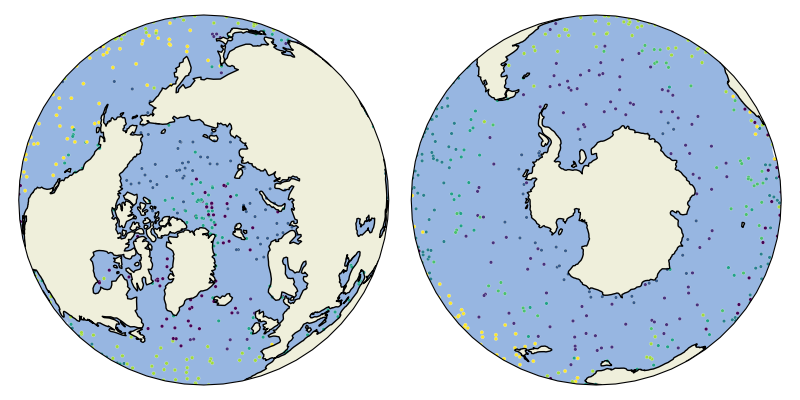

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import gridspec

# Assuming 'trajectories' is a list of dictionaries, where each dictionary contains 'lon' and 'lat'
# And 'clustering' is a list of cluster IDs corresponding to each particle


# Create figure and axes
fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(ncols=8, nrows=4, figure=fig)

# Prepare for initial scatter plot
times = starttime
lats = []
lons = []
for trajelem in trajectories:
    lona = trajelem["lon"][times]
    lons.append(lona)

    lata = trajelem["lat"][times]
    lats.append(lata)
stack = np.vstack((np.array(lons), np.array(lats))).transpose()

### Northern Hemisphere
ax1 = fig.add_subplot(
    gs[:, :4],
    projection=ccrs.NearsidePerspective(
        central_latitude=90, central_longitude=-30, satellite_height=15000000
    ),
)
ax1.add_feature(cfeature.LAND, zorder=1)
ax1.add_feature(cfeature.OCEAN, zorder=1)
ax1.coastlines()

# Apply color mapping based on clustering
scat1 = ax1.scatter(
    np.array(lons),
    np.array(lats),
    marker=".",
    s=25,
    c=np.array(clustering),  # Color by cluster ID
    cmap='viridis',          # Choose colormap (viridis here)
    edgecolor="white",
    linewidth=0.15,
    transform=ccrs.PlateCarree(),
)

### Southern Hemisphere
ax2 = fig.add_subplot(
    gs[:, 4:],
    projection=ccrs.NearsidePerspective(
        central_latitude=-90, central_longitude=-30, satellite_height=15000000
    ),
)
ax2.add_feature(cfeature.LAND, zorder=1)
ax2.add_feature(cfeature.OCEAN, zorder=1)
ax2.coastlines()

# Apply color mapping based on clustering
scat2 = ax2.scatter(
    np.array(lons),
    np.array(lats),
    marker=".",
    s=25,
    c=np.array(clustering),  # Color by cluster ID
    cmap='viridis',          # Choose colormap (viridis here)
    edgecolor="white",
    linewidth=0.15,
    transform=ccrs.PlateCarree(),
)


# Animation setup
frames = np.arange(0, 20)

def animate(t):
    times = t + starttime
    lats = []
    lons = []
    clusters = []  
    for idx, trajelem in enumerate(trajectories):
        lona = trajelem["lon"][times]
        lons.append(lona)

        lata = trajelem["lat"][times]
        lats.append(lata)
        
        # Append the cluster ID from the clustering list for this particle
        clusters.append(clustering[idx])

    stack = np.vstack((np.array(lons), np.array(lats))).transpose()

    # Normalize the clustering values to map to a color scale
    norm = plt.Normalize(min(clusters), max(clusters))  # Normalize cluster IDs
    cmap = cm.viridis  # Or any other colormap

    # Update scatter plot with new data and color mapping
    scat1.set_offsets(stack)
    scat1.set_array(np.array(clusters))  # Set cluster IDs as color values

    scat2.set_offsets(stack)
    scat2.set_array(np.array(clusters))  # Set cluster IDs as color values

    return scat1, scat2

# Create the animation
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=150, blit=True)
plt.tight_layout()


writergif = PillowWriter(fps=6)
anim.save('trajectories_animation_parcels_spectral_8clusters.gif', writer=writergif, savefig_kwargs={"transparent": True})
